# Modelo

## Librerias Necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, accuracy_score, classification_report, average_precision_score ,precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


## Lectura y Preparación de Datos 

In [2]:
df = pd.read_csv("heart.csv")

In [3]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df['RestingBP'] = df['RestingBP'].replace(0, np.nan)
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
df['Oldpeak'] = df['Oldpeak'].apply(lambda x: np.nan if x < 0 else x)

In [5]:
ms = df.isnull().sum()
ms

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak            13
ST_Slope            0
HeartDisease        0
dtype: int64

In [6]:
missing_percent = (df.isnull().mean() * 100).round(2)

missing_df = pd.DataFrame({
    "Valores Faltantes": ms,
    "Porcentaje (%)": missing_percent
})

missing_df[missing_df["Valores Faltantes"] > 0]

,Valores Faltantes,Porcentaje (%)
RestingBP,1,0.11
Cholesterol,172,18.74
Oldpeak,13,1.42


## Partición de Datos Antes de Imputar para Evitar Data Leakage

### Definimos Las Variables Para El estudio

In [7]:
target = "HeartDisease"
features = df.columns.drop(target)

In [8]:
X = df[features]
y = df[target]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Creación de Pipelines

### Manejo De Outliers

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class ManejoAtipicos(BaseEstimator, TransformerMixin):
    def __init__(self, metodo="iqr", estrategia="winsorizar"):
        
        self.metodo = metodo
        self.estrategia = estrategia
        self.limites_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            if self.metodo == "iqr":
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lim_inf = Q1 - 1.5 * IQR
                lim_sup = Q3 + 1.5 * IQR
            elif self.metodo == "percentil":
                lim_inf = X[col].quantile(0.01)
                lim_sup = X[col].quantile(0.99)
            else:
                raise ValueError("Método no soportado")
            
            self.limites_[col] = (lim_inf, lim_sup)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            lim_inf, lim_sup = self.limites_[col]
            if self.estrategia == "eliminar":
                X = X[(X[col] >= lim_inf) & (X[col] <= lim_sup)]
            elif self.estrategia == "winsorizar":
                X[col] = np.where(X[col] < lim_inf, lim_inf, X[col])
                X[col] = np.where(X[col] > lim_sup, lim_sup, X[col])
        return X.reset_index(drop=True)

### Imputación

In [11]:
thr_low  = 0.05   
thr_mid  = 0.20

Definimos límites para el porcentaje de nulos 

In [12]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist() 

Separamos los tipos de variables 

In [13]:
missing_rate = X_train.isnull().mean()
missing_rate


Age               0.000000
Sex               0.000000
ChestPainType     0.000000
RestingBP         0.001362
Cholesterol       0.186649
FastingBS         0.000000
RestingECG        0.000000
MaxHR             0.000000
ExerciseAngina    0.000000
Oldpeak           0.012262
ST_Slope          0.000000
dtype: float64

Mostramos los valores nulos

In [14]:
num_low  = [c for c in num_cols if missing_rate[c] <= thr_low]
num_mid  = [c for c in num_cols if thr_low < missing_rate[c] <= thr_mid]

cat_low  = [c for c in cat_cols if missing_rate[c] <= thr_low]
cat_mid  = [c for c in cat_cols if thr_low < missing_rate[c] <= thr_mid]

Separamos por porcentaje de nulos las variables numéricas y categóricas

#### Pipelines

In [15]:
num_pipe_low = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("outliers", ManejoAtipicos(metodo="iqr", estrategia="winsorizar")),
    ("scaler", StandardScaler())
])

num_pipe_mid = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("outliers", ManejoAtipicos(metodo="iqr", estrategia="winsorizar")),
    ("scaler", StandardScaler())
])


cat_pipe_low = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

cat_pipe_high = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


Definimos los Pipelines para todos los modelos

In [16]:
transformers = []
if num_low:  transformers.append(("num_low",  num_pipe_low,  num_low))
if num_mid:  transformers.append(("num_mid",  num_pipe_mid,  num_mid))
if cat_low:  transformers.append(("cat_low",  cat_pipe_low,  cat_low))
if cat_mid:  transformers.append(("cat_high", cat_pipe_high, cat_mid))


preprocess = ColumnTransformer(transformers, remainder="drop")

Definimos el preprocesamiento con los pipelines

## Modelos 

In [17]:
def eval_on_test(name, estimator, X_test, y_test):
    y_pred  = estimator.predict(X_test)
    y_prob  = estimator.predict_proba(X_test)[:, 1]
    return {
        "model": name,
        "auc_roc": roc_auc_score(y_test, y_prob),
        "pr_auc": average_precision_score(y_test, y_prob),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "best_estimator": estimator
    }

results = []

### `SVC`

In [18]:
svc = SVC(probability=True)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("svc", svc)
])

param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": [0.01, 0.1]
}

svc_grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
svc_grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", svc_grid.best_params_)

Mejores hiperparámetros: {'svc__C': 1, 'svc__gamma': 0.01}


#### `SVC` con los mejores parámetros

In [19]:
b_param_grid = svc_grid.best_params_

b_svc = SVC(probability=True, C=b_param_grid["svc__C"], gamma=b_param_grid["svc__gamma"])

b_svc_pipe = Pipeline([
    ("preprocess", preprocess),
    ("svc", b_svc)
])

b_svc_pipe.fit(X_train, y_train)    

svc_pred_y = b_svc_pipe.predict(X_test)

svc_prob_y = b_svc_pipe.predict_proba(X_test)[:, 1]



#### Resultados `SVC`

In [20]:
auc_roc_svc = roc_auc_score(y_test, svc_prob_y)


Resultados sklearn:
accuracy: 0.8424
precision: 0.8824
recall: 0.8411
f1: 0.8612
roc_auc_svc: 0.9186

Confusion matrix:

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82        77
           1       0.88      0.84      0.86       107

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



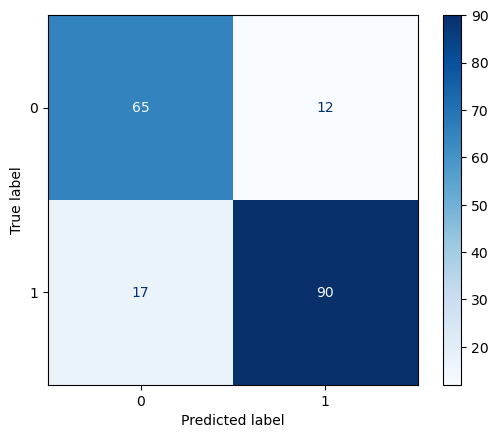

In [21]:
metricas = {
    "accuracy": accuracy_score(y_test, svc_pred_y),
    "precision": precision_score(y_test, svc_pred_y, zero_division=0),
    "recall": recall_score(y_test, svc_pred_y, zero_division=0),
    "f1": f1_score(y_test, svc_pred_y, zero_division=0),
    "roc_auc_svc": roc_auc_score(y_test, svc_prob_y)
}



print("\nResultados sklearn:")
for k,v in metricas.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion matrix:\n", ConfusionMatrixDisplay.from_predictions(y_test, svc_pred_y, cmap="Blues"))
print("\nReporte de clasificación:\n", classification_report(y_test, svc_pred_y, zero_division=0))

#### Curva ROC

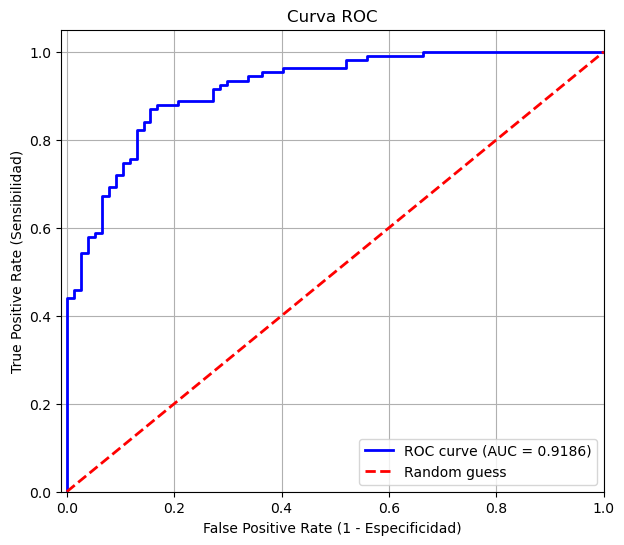

In [22]:
sc_fpr, sc_tpr, thresholds = roc_curve(y_test, svc_prob_y)


roc_auc_sc = auc(sc_fpr, sc_tpr)


plt.figure(figsize=(7,6))
plt.plot(sc_fpr, sc_tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_sc:.4f})")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--", label="Random guess")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### `KNN`

In [23]:
knn = KNeighborsClassifier()

pipe = Pipeline([
    ("preprocess", preprocess),
    ("knn", knn)
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]   
}

knn_grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
knn_grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", knn_grid.best_params_)

c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Mejores hiperparámetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}


#### `KNN` con los mejores parámetros

In [24]:
b_param_grid = knn_grid.best_params_

b_knn = KNeighborsClassifier(n_neighbors=b_param_grid["knn__n_neighbors"],
                             weights=b_param_grid["knn__weights"],
                             metric=b_param_grid["knn__metric"])

b_knn_pipe = Pipeline([
    ("preprocess", preprocess),
    ("knn", b_knn)
])

b_knn_pipe.fit(X_train, y_train)    

knn_pred_y = b_knn_pipe.predict(X_test)

knn_prob_y = b_knn_pipe.predict_proba(X_test)[:, 1]


#### Resultados `KNN`

In [25]:
auc_roc_knn = roc_auc_score(y_test, knn_prob_y)


Resultados sklearn:
accuracy: 0.8587
precision: 0.8932
recall: 0.8598
f1: 0.8762
roc_auc_knn: 0.9246

Confusion matrix:

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84        77
           1       0.89      0.86      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



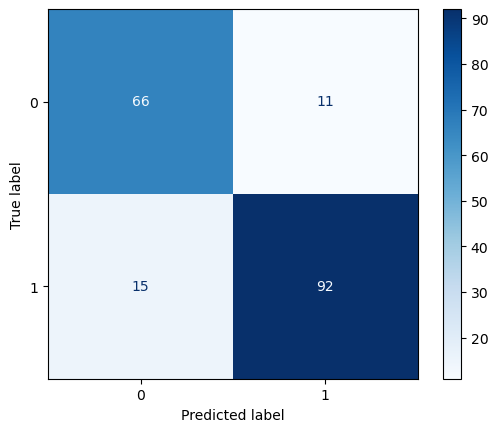

In [26]:
metricas = {
    "accuracy": accuracy_score(y_test, knn_pred_y),
    "precision": precision_score(y_test, knn_pred_y, zero_division=0),
    "recall": recall_score(y_test, knn_pred_y, zero_division=0),
    "f1": f1_score(y_test, knn_pred_y, zero_division=0),
    "roc_auc_knn": roc_auc_score(y_test, knn_prob_y)
}



print("\nResultados sklearn:")
for k,v in metricas.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion matrix:\n", ConfusionMatrixDisplay.from_predictions(y_test, knn_pred_y, cmap="Blues"))
print("\nReporte de clasificación:\n", classification_report(y_test, knn_pred_y, zero_division=0))

#### Curva ROC

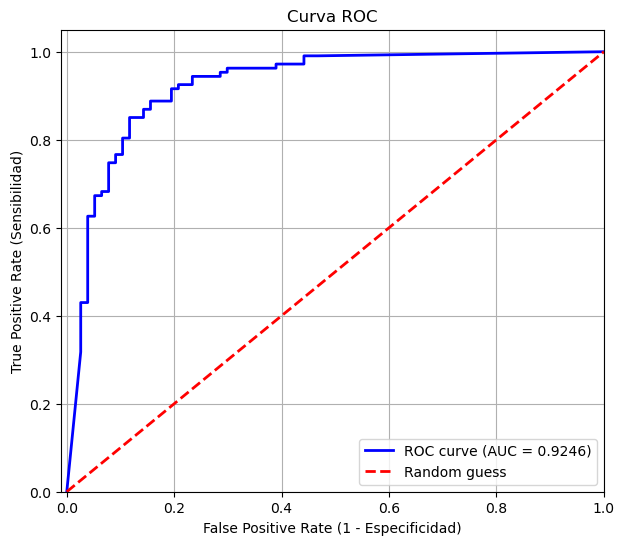

In [27]:
sc_fpr, sc_tpr, thresholds = roc_curve(y_test, knn_prob_y)


roc_auc_sc = auc(sc_fpr, sc_tpr)


plt.figure(figsize=(7,6))
plt.plot(sc_fpr, sc_tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_sc:.4f})")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--", label="Random guess")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### `LogisticRegression`

In [28]:
lg = LogisticRegression(max_iter=1000)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("lg", lg)
])

param_grid = {
    "lg__C": [0.01, 0.1, 1, 10, 100]
}

lg_grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
lg_grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", lg_grid.best_params_)

Mejores hiperparámetros: {'lg__C': 0.1}


#### `LogisticRegression` con los mejores parámetros

In [29]:
b_param_grid = lg_grid.best_params_

b_lg = LogisticRegression(C=b_param_grid["lg__C"], max_iter=1000)

b_lg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("lg", b_lg)
])

b_lg_pipe.fit(X_train, y_train)    

lg_pred_y = b_lg_pipe.predict(X_test)

lg_prob_y = b_lg_pipe.predict_proba(X_test)[:, 1]



#### Resultados `LogisticRegression`


Resultados sklearn:
accuracy: 0.8478
precision: 0.9072
recall: 0.8224
f1: 0.8627
roc_auc_lg: 0.9188

Confusion matrix:

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83        77
           1       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



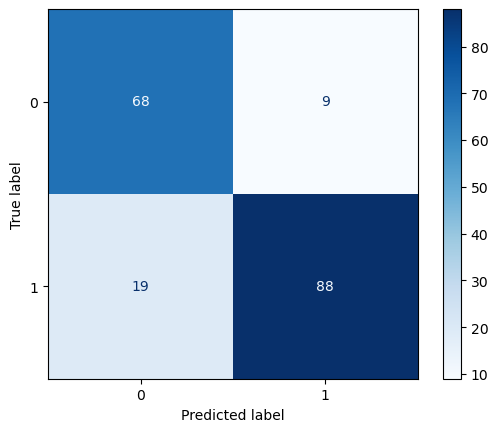

In [30]:
metricas = {
    "accuracy": accuracy_score(y_test, lg_pred_y),
    "precision": precision_score(y_test, lg_pred_y, zero_division=0),
    "recall": recall_score(y_test, lg_pred_y, zero_division=0),
    "f1": f1_score(y_test, lg_pred_y, zero_division=0),
    "roc_auc_lg": roc_auc_score(y_test, lg_prob_y)
}

roc_auc_lg = roc_auc_score(y_test, lg_prob_y)

print("\nResultados sklearn:")
for k,v in metricas.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion matrix:\n", ConfusionMatrixDisplay.from_predictions(y_test, lg_pred_y, cmap="Blues"))
print("\nReporte de clasificación:\n", classification_report(y_test, lg_pred_y, zero_division=0))

#### Curva ROC

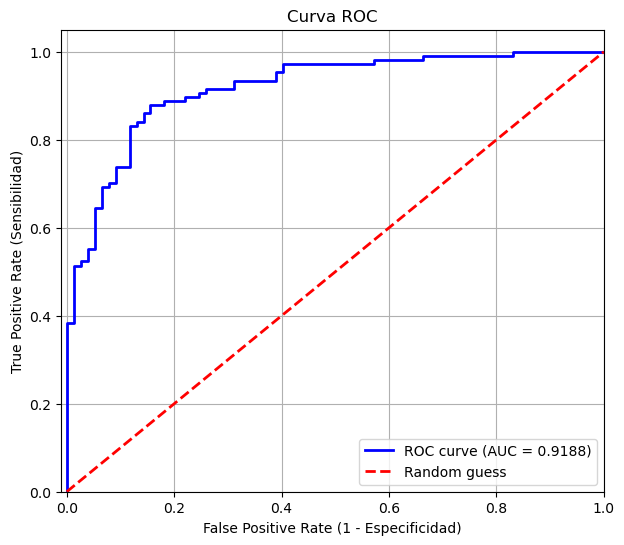

In [31]:
sc_fpr, sc_tpr, thresholds = roc_curve(y_test, lg_prob_y)


roc_auc_sc = auc(sc_fpr, sc_tpr)


plt.figure(figsize=(7,6))
plt.plot(sc_fpr, sc_tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_sc:.4f})")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--", label="Random guess")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### `Naive Bayes`

In [32]:
nb = GaussianNB()

pipe = Pipeline([
    ("preprocess", preprocess),
    ("nb", nb)
])

param_grid = {
    "nb__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
nb_grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", nb_grid.best_params_)

Mejores hiperparámetros: {'nb__var_smoothing': 1e-09}


#### `Naive Bayes` con los mejores parámetros

In [33]:
b_param_grid = nb_grid.best_params_

b_nb = GaussianNB(var_smoothing=b_param_grid["nb__var_smoothing"]) 

b_nb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("nb", b_nb)
])

b_nb_pipe.fit(X_train, y_train)    

nb_pred_y = b_nb_pipe.predict(X_test)

nb_prob_y = b_nb_pipe.predict_proba(X_test)[:, 1]



#### Resultados `Naive Bayes`


Resultados sklearn:
accuracy: 0.7989
precision: 0.8977
recall: 0.7383
f1: 0.8103
roc_auc_nb: 0.9084

Confusion matrix:

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.71      0.88      0.79        77
           1       0.90      0.74      0.81       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.82      0.80      0.80       184



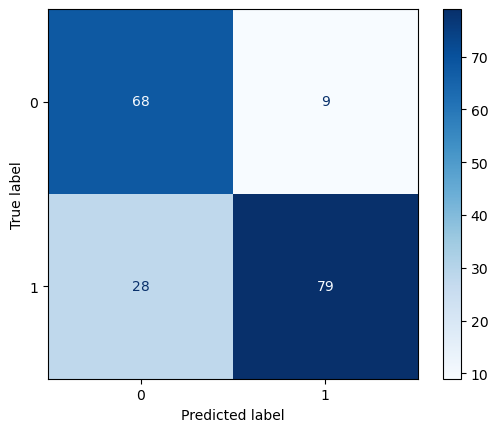

In [34]:
metricas = {
    "accuracy": accuracy_score(y_test, nb_pred_y),
    "precision": precision_score(y_test, nb_pred_y, zero_division=0),
    "recall": recall_score(y_test, nb_pred_y, zero_division=0),
    "f1": f1_score(y_test, nb_pred_y, zero_division=0),
    "roc_auc_nb": roc_auc_score(y_test, nb_prob_y)
}

roc_auc_nb = roc_auc_score(y_test, nb_prob_y)

print("\nResultados sklearn:")
for k,v in metricas.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion matrix:\n", ConfusionMatrixDisplay.from_predictions(y_test, nb_pred_y, cmap="Blues"))
print("\nReporte de clasificación:\n", classification_report(y_test, nb_pred_y, zero_division=0))

#### Curva ROC

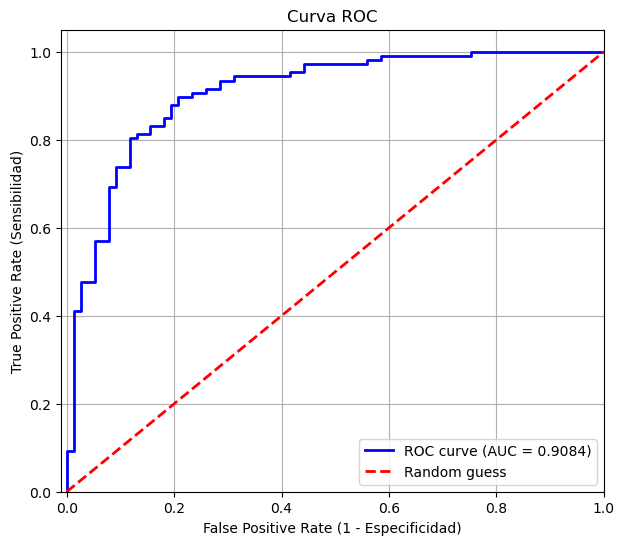

In [35]:
sc_fpr, sc_tpr, thresholds = roc_curve(y_test, nb_prob_y)


roc_auc_sc = auc(sc_fpr, sc_tpr)


plt.figure(figsize=(7,6))
plt.plot(sc_fpr, sc_tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_sc:.4f})")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--", label="Random guess")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### `RandomForest`

In [36]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("rf", rf)
])

param_grid = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
rf_grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", rf_grid.best_params_)

Mejores hiperparámetros: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


#### `RandomForest` con los mejores parámetros

In [37]:
b_param_grid = rf_grid.best_params_

b_rf = RandomForestClassifier(n_estimators=b_param_grid["rf__n_estimators"],
                                  max_depth=b_param_grid["rf__max_depth"],
                                  min_samples_split=b_param_grid["rf__min_samples_split"])

b_rf_pipe = Pipeline([
    ("preprocess", preprocess),
    ("rf", b_rf)
])

b_rf_pipe.fit(X_train, y_train)    

rf_pred_y = b_rf_pipe.predict(X_test)

rf_prob_y = b_rf_pipe.predict_proba(X_test)[:, 1]



#### Resultados `RandomForest`


Resultados sklearn:
accuracy: 0.8533
precision: 0.8922
recall: 0.8505
f1: 0.8708
roc_auc_rf: 0.9320

Confusion matrix:

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        77
           1       0.89      0.85      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184



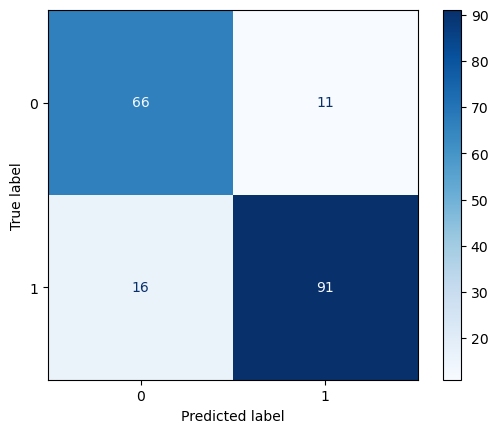

In [38]:
metricas = {
    "accuracy": accuracy_score(y_test, rf_pred_y),
    "precision": precision_score(y_test, rf_pred_y, zero_division=0),
    "recall": recall_score(y_test, rf_pred_y, zero_division=0),
    "f1": f1_score(y_test, rf_pred_y, zero_division=0),
    "roc_auc_rf": roc_auc_score(y_test, rf_prob_y)
}

roc_auc_rf = roc_auc_score(y_test, rf_prob_y)

print("\nResultados sklearn:")
for k,v in metricas.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion matrix:\n", ConfusionMatrixDisplay.from_predictions(y_test, rf_pred_y, cmap="Blues"))
print("\nReporte de clasificación:\n", classification_report(y_test, rf_pred_y, zero_division=0))

#### Curva ROC

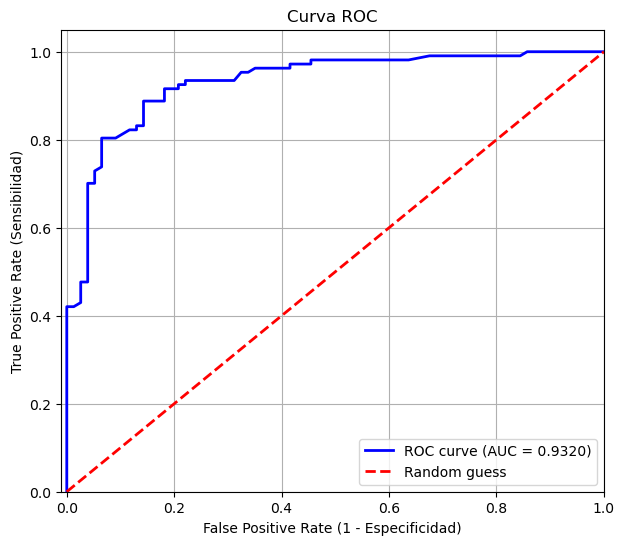

In [39]:
sc_fpr, sc_tpr, thresholds = roc_curve(y_test, rf_prob_y)


roc_auc_sc = auc(sc_fpr, sc_tpr)


plt.figure(figsize=(7,6))
plt.plot(sc_fpr, sc_tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_sc:.4f})")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--", label="Random guess")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### `Xgboost`

In [40]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", tree_method="hist", random_state=42,n_jobs=-1)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("xgb", xgb)
])

param_grid = {
    "xgb__n_estimators": [200, 400],
    "xgb__max_depth": [3, 4, 6],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0],
    "xgb__min_child_weight": [1, 3],
    "xgb__reg_lambda": [1, 5],
    "xgb__reg_alpha": [0, 0.1]
}

xgb_grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
xgb_grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", xgb_grid.best_params_)

c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\mming\miniconda3\envs\vi

Mejores hiperparámetros: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}


c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\model_selection\_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\model_selection\_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\metrics\_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mming\miniconda3\envs\viz_ok\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\mming\miniconda3\envs\vi

#### `Xgboost` con los mejores parámetros

In [41]:
b_param_grid = xgb_grid.best_params_

b_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    n_estimators=b_param_grid["xgb__n_estimators"],
    max_depth=b_param_grid["xgb__max_depth"],
    learning_rate=b_param_grid["xgb__learning_rate"],
    subsample=b_param_grid["xgb__subsample"],
    colsample_bytree=b_param_grid["xgb__colsample_bytree"],
    min_child_weight=b_param_grid["xgb__min_child_weight"],
    reg_lambda=b_param_grid["xgb__reg_lambda"],
    reg_alpha=b_param_grid["xgb__reg_alpha"]
)


b_xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("xgb", b_xgb)
])

b_xgb_pipe.fit(X_train, y_train)     

xgb_pred_y = b_lg_pipe.predict(X_test)

xgb_prob_y = b_lg_pipe.predict_proba(X_test)[:, 1]



#### Resultados `Xgboost`


Resultados sklearn:
accuracy: 0.8478
precision: 0.9072
recall: 0.8224
f1: 0.8627
roc_auc_xgb: 0.9188

Confusion matrix:

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83        77
           1       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



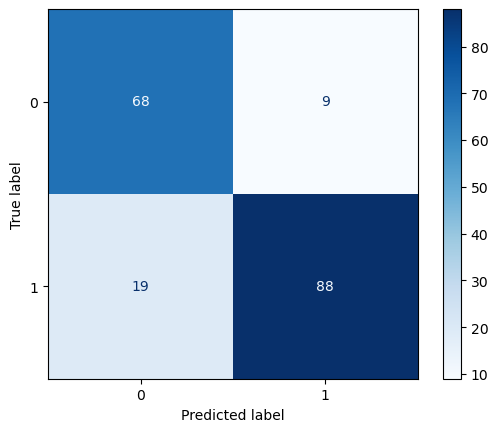

In [42]:
metricas = {
    "accuracy": accuracy_score(y_test, xgb_pred_y),
    "precision": precision_score(y_test, xgb_pred_y, zero_division=0),
    "recall": recall_score(y_test, xgb_pred_y, zero_division=0),
    "f1": f1_score(y_test, xgb_pred_y, zero_division=0),
    "roc_auc_xgb": roc_auc_score(y_test, xgb_prob_y)
}

roc_auc_xgb = roc_auc_score(y_test, xgb_prob_y)

print("\nResultados sklearn:")
for k,v in metricas.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion matrix:\n", ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred_y, cmap="Blues"))
print("\nReporte de clasificación:\n", classification_report(y_test, xgb_pred_y, zero_division=0))

#### Curva ROC

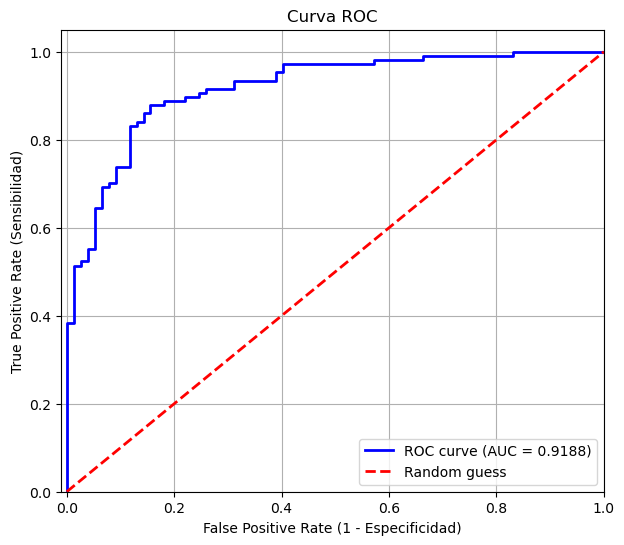

In [43]:
sc_fpr, sc_tpr, thresholds = roc_curve(y_test, xgb_prob_y)


roc_auc_sc = auc(sc_fpr, sc_tpr)


plt.figure(figsize=(7,6))
plt.plot(sc_fpr, sc_tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_sc:.4f})")
plt.plot([0,1], [0,1], color="red", lw=2, linestyle="--", label="Random guess")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [44]:
resultados_auc = {
    "SVC": auc_roc_svc,
    "KNN": auc_roc_knn,
    "Logistic Regression": roc_auc_lg,
    "Random Forest": roc_auc_rf,
    "XGBoost": roc_auc_xgb
}

# Crear DataFrame de comparación
df_auc = pd.DataFrame.from_dict(resultados_auc, orient='index', columns=['AUC'])
df_auc = df_auc.sort_values(by='AUC', ascending=False)


In [45]:
df_auc

,AUC
Random Forest,0.931970
KNN,0.924566
Logistic Regression,0.918801
XGBoost,0.918801
SVC,0.918558


,Accuracy,Precision,Recall,F1,AUC
Modelo,,,,,
SVC,0.842391,0.882353,0.841121,0.861244,0.918558
KNN,0.858696,0.893204,0.859813,0.876190,0.924566
Logistic Regression,0.847826,0.907216,0.822430,0.862745,0.918801
Naive Bayes,0.798913,0.897727,0.738318,0.810256,0.908363
Random Forest,0.853261,0.892157,0.850467,0.870813,0.931970
XGBoost,0.847826,0.907216,0.822430,0.862745,0.918801


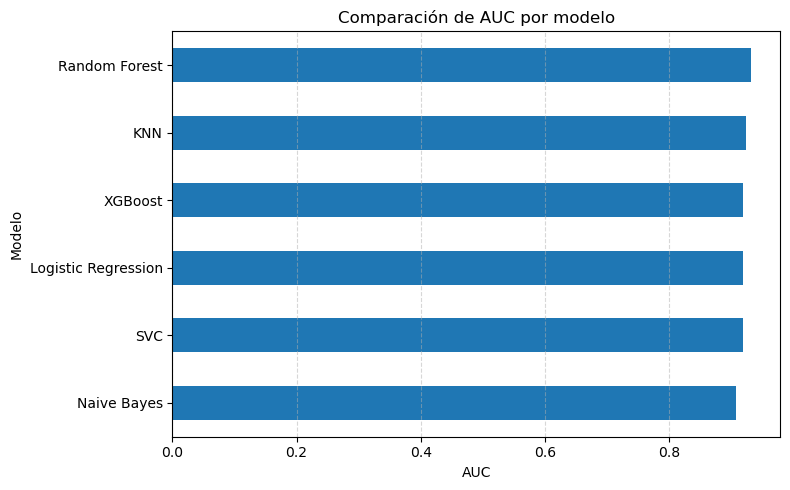

<Figure size 1000x600 with 0 Axes>

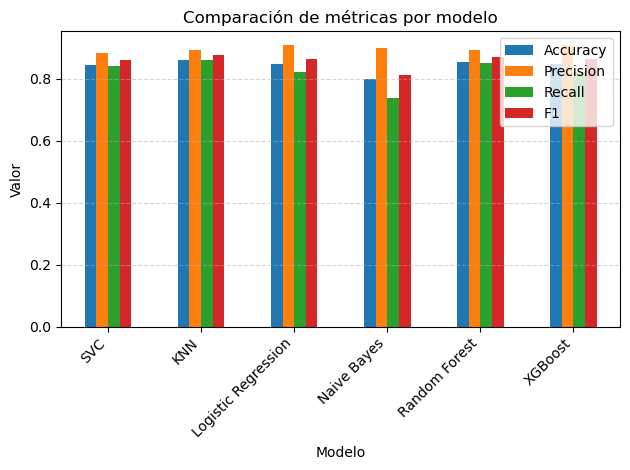

In [ ]:
modelos_pred = {
    "SVC": svc_pred_y,
    "KNN": knn_pred_y,
    "Logistic Regression": lg_pred_y,
    "Naive Bayes": nb_pred_y,
    "Random Forest": rf_pred_y,
    "XGBoost": xgb_pred_y
}

modelos_proba = {
    "SVC": svc_prob_y,
    "KNN": knn_prob_y,
    "Logistic Regression": lg_prob_y,
    "Naive Bayes": nb_prob_y,
    "Random Forest": rf_prob_y,
    "XGBoost": xgb_prob_y
}

# ============================================
# Recolectar todas las métricas automáticamente
# ============================================

resultados = []

for nombre in modelos_pred:
    y_pred = modelos_pred[nombre]
    y_prob = modelos_proba[nombre]

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })

df_resultados = pd.DataFrame(resultados).set_index("Modelo")
display(df_resultados)


# ============================================
# Gráfica comparativa de Accuracy, Precision, Recall y F1
# ============================================

plt.figure(figsize=(10, 6))
df_resultados[["Accuracy", "Precision", "Recall", "F1"]].plot(kind="bar")
plt.title("Comparación de métricas por modelo")
plt.ylabel("Valor")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
